# How to Create a Differentiable Model:
## River Routing Notebook

- Example: dMC-Juniata Routing
- Data Location: https://doi.org/10.1029/2023WR035337

## Step 1: Download the data and build our config

In [ ]:
# from pathlib import Path
# import os

# # Create the data dir
# data_folder = Path("../data")
# data_folder.mkdir(exist_ok=True)

# # Change the current working directory to "../data"
# os.chdir("../data")

# # Print the current working directory
# os.getcwd()

# # Download the routing dataset using wget and save it as 'CAMELS.zip'
# output_path = Path("../data/dMC-Juniata-hydroDL2")
# if output_path.exists():
#     print("data already downloaded")
# else:
#     !wget --no-check-certificate 'https://zenodo.org/records/10183429/files/dMC-Juniata-hydroDL2.zip?download=1' -O 'routing.zip'
#     !unzip 'routing.zip'

data already downloaded


Now go into the `dMC/conf/global_settings.yaml` file and change the `cwd` entry to your project working directory

Once this is complete, we will import our functions:

In [1]:
# Python Lib Packages
import os
from pathlib import Path
import sys

# Pypi imported Modules
import hydra
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import DictConfig, OmegaConf
import pandas as pd
import torch
import torch.nn as nn

# Putting the dMC module in the Python Path
current_dir = Path.cwd()
dmc_dev_path = current_dir.parents[1]
sys.path.append(str(dmc_dev_path))

# Import MLP Network
from dMC.nn.mlp import MLP
from dMC.nn import Initialization

# Physics model
from dMC.physics.explicit_mc import ExplicitMC

# Experiment
from dMC.experiments.train_mlp import TrainModel
from dMC.experiments.writer import Writer

# Utils functions
from dMC.__main__ import _set_defaults

# Required to generate data
from dMC.data.datasets.nhd_srb import NHDSRB
from dMC.data.observations.usgs import USGS
from dMC.data.dates import Dates
from dMC.data.normalize.min_max import MinMax
from dMC.data import DataLoader

# For evaluation
from dMC.experiments.metrics import Metrics

/home/tbindas/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
config_path = "../../dMC/conf"
with hydra.initialize(config_path=config_path, version_base="1.3"):
    cfg = hydra.compose(config_name="global_settings.yaml", return_hydra_config=True)

# cfg = _set_defaults(cfg)

# Let's change the epochs to 2 so we can easily see updates
cfg.config.experiment.epochs = 50

Now we're done! There are a lot of potential configurations, however, we are only going to focus on the MLP code today from the training against US Geological Survey Data example

# Step 2: Set up your dataset:

In [12]:
cfg_data = cfg.config.data

dates = Dates(cfg_data)  # Dates Object
normalize = MinMax(cfg_data)  # Normalization Object
data = NHDSRB(cfg_data, dates=dates, normalize=normalize)  # Dataset Object
obs = USGS(cfg_data, dates, normalize)  # Observations Object

# Getting the data
hydrofabric = data.get_data()
observations = obs.get_data().transpose(0, 1)

dataloader =  DataLoader(data, obs)(cfg_data)
dataloader

/projects/mhpi/tbindas/dmc-explicit/dMC/data/dates/__init__.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self._large_interval = pd.date_range(


Let's go through this data a bit more to make things easier to understand.

Below is the map of the study area, the Juniata River Basin. 

Unlike in most deep learning applications where we use a lumped basin prediction approach where basin attributes are averaged over a geospatial area, in distributed streamflow predictions, we have many attributes spead over a large region

![A map of the data](data_map.png "Title")

data.attributes.shape

In [13]:
pd.read_csv(data.cfg.csv.edges).head()

,id,code,fromNode,toNode,w,E,S0,AreaSqKM,TotDASqKM,AreaPerLenKM,sinuosity,ZBank,d,ComID
0,1,r294c2,1,2,11.427123,84.892337,0.002700,4.718534,6.384434,2.466426,1.054535,85.535748,1916.7645,8140140
1,2,r294c3,2,3,11.427123,80.986017,0.001185,4.718534,11.102967,2.466426,1.054535,81.618387,1916.7645,8140140
2,3,r294c4,3,4,11.427123,78.465875,0.001827,4.718534,15.821501,2.466426,1.054535,79.119464,1916.7645,8140140
3,4,r294c5,4,5,11.427123,75.953580,0.000624,4.718534,20.540034,2.466426,1.054535,76.593397,1916.7645,8140140
4,5,r294c6,5,6,14.116864,74.574937,0.000551,5.552471,26.092506,2.466426,1.167813,75.271625,1916.7645,8140002


In this example, we have a graph consisting of 583 nodes, and 10 attributes:
- river width
- elevation
- slope
- area of the river reach
- total drainage area
- area per length of river
- sinousity
- river bank height
- River reach length

Since these attributes have to go into a Neural Network, we will need to use a Min/Max Normalization method to scale all inputs between 0 to 1.

The MinMax Scaling method is:
```
(X - X_min) / (X_max - X_min)
```


In [15]:
normalize.scalar

MinMaxScaler()

This data has to have a time range for training. We define that with a `Dates` object in charge of all timestamping

In [16]:
dates.time_interval

array(['02/01/2001 00:00:00', '02/01/2001 01:00:00',
       '02/01/2001 02:00:00', ..., '03/28/2001 21:00:00',
       '03/28/2001 22:00:00', '03/28/2001 23:00:00'], dtype=object)

Lastly, we need truth values to compare our routed results to. These come from the US Geological Survey (USGS). In this example, we are comparing to the downstream-most node for eight weeks of hourly data. 

In [17]:
obs.observations.shape

torch.Size([1344, 1])

We can package this code up together into an object that represents the "Hydrofabric", and then load it into a pytorch dataloader, which iterates over our dataset for training purposes

In [18]:
hydrofabric

Hydrofabric(attributes=tensor([[8.6940e+00, 8.1806e+01, 2.9328e-03,  ..., 8.2342e+01, 1.7706e+03,
         4.6901e+06],
        [8.6940e+00, 7.6588e+01, 1.9811e-03,  ..., 7.7105e+01, 1.7706e+03,
         4.6890e+06],
        [9.9533e+00, 7.3299e+01, 1.4209e-03,  ..., 7.3882e+01, 1.7706e+03,
         4.6890e+06],
        ...,
        [1.0769e+02, 3.2069e+01, 1.7176e-04,  ..., 3.5094e+01, 1.9967e+03,
         4.7002e+06],
        [1.0862e+02, 3.1709e+01, 2.2679e-04,  ..., 3.4737e+01, 1.9967e+03,
         4.7002e+06],
        [1.0862e+02, 3.1379e+01, 1.1095e-04,  ..., 3.4406e+01, 1.9967e+03,
         4.7001e+06]], dtype=torch.float64), forcings=tensor([[0.1149, 0.0978, 0.0627,  ..., 0.0500, 0.0428, 0.1000],
        [0.1133, 0.0965, 0.0619,  ..., 0.0499, 0.0427, 0.0997],
        [0.1117, 0.0951, 0.0610,  ..., 0.0497, 0.0425, 0.0994],
        ...,
        [0.1150, 0.0980, 0.0628,  ..., 0.0699, 0.0598, 0.1398],
        [0.1179, 0.1004, 0.0644,  ..., 0.0724, 0.0619, 0.1446],
        [0.1208, 

In [19]:
dataloader

# Step 2: Choose your model

In [22]:
cfg_model = cfg.config.model

neural_network = MLP(cfg=cfg_model).to(cfg_model.device)
# neural_network = SingleParameters(cfg=cfg_model).to(cfg_model.device)
# neural_network = Power(cfg=cfg_model).to(cfg_model.device)
# ... etc (see imports for all options)

physics_model = ExplicitMC(cfg=cfg_model, neural_network=neural_network)
physics_model

ExplicitMC(
  (neural_network): MLP(
    (layers): Sequential(
      (0): Linear(in_features=8, out_features=6, bias=True)
      (1): Linear(in_features=6, out_features=6, bias=True)
      (2): Linear(in_features=6, out_features=6, bias=True)
      (3): Linear(in_features=6, out_features=2, bias=True)
      (4): Sigmoid()
    )
  )
)

In this case, we're choosing a Multilayered Perceptron model, (MLP), coupled with the Muskingum-Cunge Equation. An MLP is a combination of Linear layers and activation functions. In our case, we use a relatively shallow MLP as:
1. This is a very small river network
2. We are passing in static attribute data to our model

This MLP can be subsituted out for whatever you would want.

Notice how the output features are 2. This means we will be predicting two variables:
1. Manning's roughness (n)
2. An exponential channel geometry variable (q_spatial)

# Step 3: Choose your experiment

In [31]:
cfg_experiment = cfg.config.experiment
writer = Writer(cfg_experiment)
experiment = TrainModel(cfg=cfg_experiment, writer=writer)
experiment

We are using a class called, `Writer` so we can track metrics and statistics (using tensorboard) during the training run

In [24]:
writer.metrics.nse

<bound method Metrics.nse of <dMC.experiments.metrics.Metrics object at 0x7f16dea902d0>>

The experiment class is very similar to a `Trainer` function. All of the experiments have the same base class, and can be swapped depending on what we want to do (train, validate, test, etc)

In [25]:
experiment

# Step 4: Run the experiment!

In [32]:
experiment.run(dataloader, physics_model)

Epoch 1: Explicit Muskingum Cunge Routing:   0%|          | 0/1343 [00:00<?, ?it/s]

Epoch 50: Explicit Muskingum Cunge Routing: 100%|██████████| 1343/1343 [00:40<00:00, 33.13it/s]


In [33]:
physics_model.neural_network

MLP(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=6, bias=True)
    (1): Linear(in_features=6, out_features=6, bias=True)
    (2): Linear(in_features=6, out_features=6, bias=True)
    (3): Linear(in_features=6, out_features=2, bias=True)
    (4): Sigmoid()
  )
)

In [44]:
predictions = np.load("/projects/mhpi/tbindas/dmc-explicit/output/final_paper_output/01_workshop_example_predictions_epoch_50.npy")

experiment.writer.metrics.nse(predictions=predictions.squeeze(), observations=obs.observations.numpy().squeeze())

0.8040954931849136

In [43]:
obs.observations.numpy().squeeze().shape

(1344,)

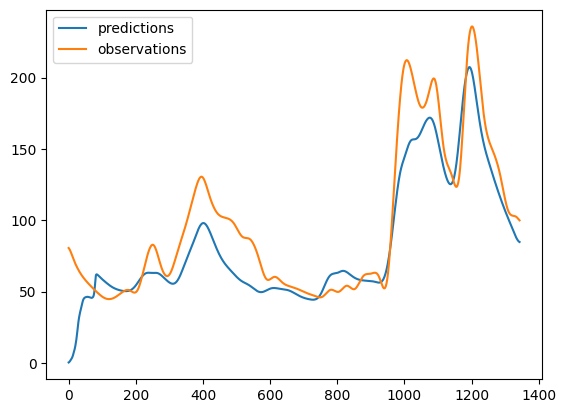

In [45]:
import matplotlib.pyplot as plt

plt.plot(range(predictions.shape[1]), predictions.squeeze(), label="predictions")
plt.plot(range(predictions.shape[1]), obs.observations.numpy().squeeze(), label="observations")

plt.legend()
plt.show()

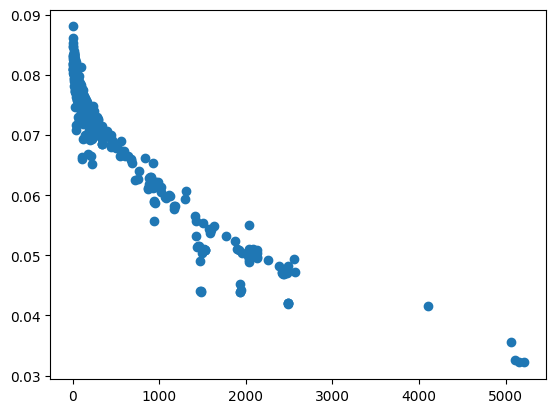

In [48]:
plt.scatter(data._areas, physics_model.n.detach().numpy())